# Neural Architecture Search using NASBench-101

This notebook is based on papers https://arxiv.org/abs/1902.09635 and https://arxiv.org/abs/1903.11059
and the code is partially taken from notebook at: https://github.com/google-research/nasbench. Helper script is assembled from code using code from https://github.com/romulus0914/NASBench-PyTorch

NASBench-101 is a dataset of CNN architectures that are evaluated on CIFAR-10 dataset for different number of epochs. 

The goal of this notebook is 
1. To compare performance of different search algorithms for this dataset. 
2. To gain some insights about this dataset. 
3. To compare performance of sampled architectures on some other dataset compared to its performance on CIFAR-10. 



In [33]:
#standard imports
import os
import time
import pandas as pd
import copy
import numpy as np
import matplotlib.pyplot as plt
import random
import collections
import math
import tarfile

#Pytorch imports
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision.transforms import ToTensor

#get nn_generation from github and import it
!git clone https://github.com/akashjorss/NAS_Search_using_NASBench-101.git
!cp ./NAS_Search_using_NASBench-101/nn_generation.py .
import nn_generation

fatal: destination path 'NAS_Search_using_NASBench-101' already exists and is not an empty directory.


In [2]:
#Mount google drive to import the dataset(Should be done only for imagennette dataset)
# from google.colab import drive
# ROOT = "/content/drive"
# drive.mount(ROOT)
# PROJ = "My Drive/DL_course/DL_Project/" # This is a custom path.
# PROJECT_PATH = os.path.join(ROOT, PROJ)

### Load NASBench library and dataset
This dataset has accuracies of ~0.5 million sampled architectures. Each architecture is trained for 12, 36 and 108 epochs on CIFAR-10 dataset. For each epoch, the architecture is trained 3 times with different random initializations. Thus, we have a rich dataset of which we can make use of in our own project. 

In [4]:
# This code was written in TF 1.12 but should be supported all the way through
# TF 1.15. Untested in TF 2.0+.
%tensorflow_version 1.x

# Download the raw data (only 108 epoch data points, for full dataset,
# uncomment the second line for nasbench_full.tfrecord).

# !curl -O https://storage.googleapis.com/nasbench/nasbench_only108.tfrecord
!curl -O https://storage.googleapis.com/nasbench/nasbench_full.tfrecord

# Clone and install the code and dependencies.

!git clone https://github.com/google-research/nasbench
!pip install ./nasbench
!pip install absl-py
# Initialize the NASBench object which parses the raw data into memory (this
# should only be run once as it takes up to a few minutes).
from nasbench import api

# Use nasbench_full.tfrecord for full dataset (run download command above).
nasbench = api.NASBench('nasbench_full.tfrecord')#os.path.join(PROJECT_PATH, 'nasbench_full.tfrecord'))

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1989M  100 1989M    0     0  99.7M      0  0:00:19  0:00:19 --:--:-- 33.0M
fatal: destination path 'nasbench' already exists and is not an empty directory.
Processing ./nasbench
  Created wheel for nasbench: filename=nasbench-1.0-cp36-none-any.whl size=46789 sha256=0fc2c8177bb7d6ced4abcad1948f46255f27e8981a3a45063896cf86051979b0
  Stored in directory: /tmp/pip-ephem-wheel-cache-uiiri17p/wheels/4b/19/99/1d5fdfe30f8b16fab91e900808f4f7e5adc38e602c84970ad5
Successfully built nasbench
  Found existing installation: nasbench 1.0
    Uninstalling nasbench-1.0:
      Successfully uninstalled nasbench-1.0


Loading dataset from file... This may take a few minutes...
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
Loaded dataset in 168 seconds


### Cell in NASBench-101.
Cell is the smallest unit of the neural network architecture. It is similar to inception like cell. Below, we define the various constants which would be useful for us in cell definition. 

In [5]:
# Useful constants
INPUT = 'input'
OUTPUT = 'output'
CONV3X3 = 'conv3x3-bn-relu'
CONV1X1 = 'conv1x1-bn-relu'
MAXPOOL3X3 = 'maxpool3x3'
NUM_VERTICES = 7
MAX_EDGES = 9
EDGE_SPOTS = NUM_VERTICES * (NUM_VERTICES - 1) / 2   # Upper triangular matrix
OP_SPOTS = NUM_VERTICES - 2   # Input/output vertices are fixed
ALLOWED_OPS = [CONV3X3, CONV1X1, MAXPOOL3X3]
ALLOWED_EDGES = [0, 1]   # Binary adjacency matrix

### Basic usage
Write a little descriptions of how cells work!
We define cell as a graph, with binary adjacency matrix. The vertices are defined in the ops list. The matrix is an upper triangular matrix to make sure that our graph is a DAG. (include a picture). The boolean value at index (i,j) in matrix tells us if there is a directed edge from ops[i] to ops[j]. 


In [6]:
# Query an Inception-like cell from the dataset.
cell = api.ModelSpec(
  matrix= [[0, 1, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 1],
          [0, 0, 0, 0, 0, 0, 1],
          [0, 0, 0, 0, 1, 0, 0],
          [0, 0, 0, 0, 0, 0, 1],
          [0, 0, 0, 0, 0, 0, 1],
          [0, 0, 0, 0, 0, 0, 0]],
  # Operations at the vertices of the module, matches order of matrix.
  ops=[INPUT, CONV1X1, CONV3X3, CONV3X3, CONV3X3, MAXPOOL3X3, OUTPUT])

# Querying multiple times may yield different results. Each cell is evaluated 3
# times at each epoch budget and querying will sample one randomly.
data = nasbench.query(cell, epochs=12)
for k, v in data.items():
  print('%s: %s' % (k, str(v)))

module_adjacency: [[0 1 0]
 [0 0 1]
 [0 0 0]]
module_operations: ['input', 'conv1x1-bn-relu', 'output']
trainable_parameters: 1920138
training_time: 59.37699890136719
train_accuracy: 0.5746194124221802
validation_accuracy: 0.5505809187889099
test_accuracy: 0.5480769276618958


We write a Cell class to make our code more compact. This would have useful functions for tree search. 

In [7]:
class Cell:
    def __init__(self, matrix = None, ops = None):
      spec = None
      if matrix is None:
        spec = self.initialize()
        while not(nasbench.is_valid(spec)):
          spec = self.initialize()
      else:
        self.matrix = matrix
        self.ops = ops
       
    def initialize(self):
      self.matrix = np.random.choice(ALLOWED_EDGES, size=(NUM_VERTICES, NUM_VERTICES))
      self.matrix = np.triu(self.matrix, 1)
      self.ops = np.random.choice(ALLOWED_OPS, size=(NUM_VERTICES)).tolist()
      self.ops[0] = INPUT
      self.ops[-1] = OUTPUT
      return api.ModelSpec(matrix=self.matrix, ops=self.ops)

    def get_id(self):
      """This generates a string which is a unique identifier for our cell"""
      id = ""
      for i in range(self.matrix.shape[0]):
        for j in range(i+1, self.matrix.shape[1]):
          id += str(self.matrix[i][j])
      for i in range(1, len(self.ops)-1):
        id += " "
        id += str(self.ops[i])
      return id
    
    def invert(self, x):
      """This toggles the value of boolean value x"""
      if x == 0:
        return 1
      else:
        return 0

    def get_children(self): 
      """Generates all the possible children by changing one bit in a cell"""
      children = []
      #generate all the combinations after changing one bit
      for i in range(self.matrix.shape[0]):
        for j in range(i+1, self.matrix.shape[1]):
          child_matrix = np.copy(self.matrix)
          child_matrix[i][j] = self.invert(child_matrix[i][j])
          if nasbench.is_valid(api.ModelSpec(matrix=child_matrix, ops=self.ops)):
            children.append(Cell(child_matrix, self.ops))
            

      for i in range(1, len(self.ops)-1):
        child_ops = self.ops.copy()
        allowed_ops = ALLOWED_OPS.copy()
        allowed_ops.remove(child_ops[i])
        child_ops[i] = np.random.choice(allowed_ops)
        if nasbench.is_valid(api.ModelSpec(matrix=self.matrix, ops=child_ops)):
          children.append(Cell(self.matrix, child_ops))
      
      return children

    def __str__(self):
      return self.get_id()
    
    @classmethod
    def construct_from_id(cls, cell_id):
      """Construct cell from id"""
      assert(type(cell_id) is str)
      matrix_str = cell_id.split(" ")[0]
      
      #create the cell matrix
      idx = 0
      matrix = np.zeros((7,7)).astype(int)
      for i in range(matrix.shape[0]):
        for j in range(i+1, matrix.shape[1]):
          matrix[i][j] = int(matrix_str[idx])
          idx += 1

      #create list of operations    
      ops = [INPUT]
      for op in cell_id.split(" ")[1:]:
        ops.append(op)
      ops.append(OUTPUT)

      return cls(matrix, ops)

    def get_test_accuracy(self, epochs, quick=True):
      spec = api.ModelSpec(self.matrix, self.ops)
      #There are 3 measurements and we want to return average
      acc = nasbench.query(spec, epochs=epochs)['test_accuracy']
      if quick:
        return acc
      accuracies = []
      while len(accuracies) < 3:
        if acc not in accuracies:
          accuracies.append(acc)
        acc = nasbench.query(spec, epochs=epochs)['test_accuracy']
      return np.average(np.array(accuracies))


    def get_val_accuracy(self, epochs, quick=True):
      spec = api.ModelSpec(self.matrix, self.ops)
      acc = nasbench.query(spec, epochs=epochs)['validation_accuracy']
      if quick:
        return acc
      accuracies = []
      while len(accuracies) < 3:
        if acc not in accuracies:
          accuracies.append(acc)
        acc = nasbench.query(spec, epochs=epochs)['validation_accuracy']
      return np.average(np.array(accuracies))

In [8]:
#Testing cell class
cell = Cell()
print(cell.matrix)
print(cell.ops)
print(cell.get_id()) 

[[0 0 1 1 0 0 1]
 [0 0 1 0 1 1 1]
 [0 0 0 0 1 1 1]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
['input', 'conv3x3-bn-relu', 'conv1x1-bn-relu', 'maxpool3x3', 'conv3x3-bn-relu', 'conv1x1-bn-relu', 'output']
011001101110111001100 conv3x3-bn-relu conv1x1-bn-relu maxpool3x3 conv3x3-bn-relu conv1x1-bn-relu


### Class for Tree Search

In [9]:
class TreeSearch:
  def __init__(self, epochs, time_budget=np.inf, C = 1, num_cells = np.inf):
    self.visited = dict({'terminal':0}) #count for each cell
    self.root = Cell() #initialize a random cell
    self.best_cell = self.root
    self.best_valids = [self.best_cell.get_val_accuracy(epochs)] #array of best acuracies so far
    self.best_tests = [self.best_cell.get_test_accuracy(epochs)]
    self.time_budget = float(time_budget) #in seconds
    self.times = [0]
    self.epochs=epochs
    self.C = C #exploration constant for UCB1
    self.num_cells = num_cells #number of cells to search

  def search(self):
    """searches the best cell (using validation accuracy) starting from root in given number of time
        or by exploring given number of cells"""
    tic = time.time()
    while True:
      current_cell = self.root
      ancestors = dict() #maintain ancestors array to prevent cycles
      while True:
        key = current_cell.get_id()
        ancestors[key] = 1 #access in dict is faster than in list
        if key in self.visited:
          self.visited[key] += 1 
        else:
          self.visited[key] = 1
        best_child = self.get_best_child(current_cell, ancestors)

        if best_child == None or best_child == 'terminal': 
          self.visited['terminal'] += 1
          break 

        best_child_acc = best_child.get_val_accuracy(self.epochs)
        if best_child_acc > self.best_valids[-1]:
          self.best_cell = best_child
          self.best_valids.append(best_child_acc)
          self.best_tests.append(best_child.get_test_accuracy(self.epochs))
        else:
          self.best_valids.append(self.best_valids[-1])
          self.best_tests.append(self.best_tests[-1])
        
        tac = time.time()
        self.times.append(tac-tic)
        if tac-tic > self.time_budget or len(self.times) > self.num_cells:
          break
        current_cell = best_child

      tac = time.time()
      if tac-tic > self.time_budget or len(self.times) > self.num_cells:
        break
  
  def get_best_child(self, cell, ancestors):
    """Returns the best child using validation accuracy and UCB1 algorithm"""

    all_children = cell.get_children()

    #remove nodes which are ancestors or are invalid
    for child in all_children:
      if child.get_id() in ancestors:
        all_children.remove(child)
    
    # if there are no more unvisited nodes
    if len(all_children) == 0:
      return None
    
    all_children.append('terminal')

    all_children_acc = list(map(lambda c: cell.get_val_accuracy(self.epochs) if c == 'terminal' else c.get_val_accuracy(self.epochs), 
                            all_children))
    all_children_n = [] #num of times certain child is visited
    for i in range(len(all_children)):
      if all_children[i] != 'terminal':
        key = all_children[i].get_id()
      else:
        key == 'terminal'
      if key in self.visited:
        all_children_n.append(self.visited[key])
      else:
        all_children_n.append(0)

    #ucb1 scores of all children 
    all_children_ucb1 = []
    parent_n = self.visited[cell.get_id()] #num of times parent node has been visited
    for i in range(len(all_children)):
      ucb1 = all_children_acc[i] + self.C*math.sqrt(2*math.log(parent_n)/(all_children_n[i]+1e-8))
      all_children_ucb1.append(ucb1)
    
    #return best child according to ucb1
    best_i = np.argmax(all_children_ucb1)

    return all_children[best_i]



Starting cell:  100000011110011000100 conv3x3-bn-relu conv1x1-bn-relu conv3x3-bn-relu maxpool3x3 conv1x1-bn-relu
[[0 1 0 1 0 1 1]
 [0 0 0 1 0 1 0]
 [0 0 0 0 1 1 0]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
['input', 'conv3x3-bn-relu', 'conv1x1-bn-relu', 'conv1x1-bn-relu', 'maxpool3x3', 'conv1x1-bn-relu', 'output']
Number of nodes visited:  385


(0.9, 0.96)

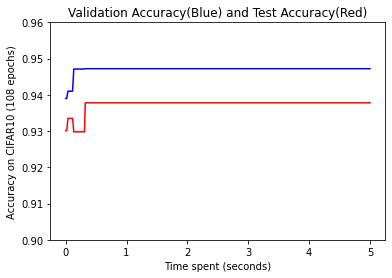

In [10]:
#Test tree search
treeSearch = TreeSearch(epochs = 108, C = 1, time_budget=5)
print("Starting cell: ", treeSearch.root)
treeSearch.search()
print(treeSearch.best_cell.matrix)
print(treeSearch.best_cell.ops)
# for key in treeSearch.visited:
#   print(key, treeSearch.visited[key])

print("Number of nodes visited: ", len(treeSearch.times) -1)
plt.plot(treeSearch.times, treeSearch.best_valids, color='blue')
plt.plot(treeSearch.times, treeSearch.best_tests, color='red')
plt.xlabel("Time spent (seconds)")
plt.ylabel("Accuracy on CIFAR10 (108 epochs)")
plt.title("Validation Accuracy(Blue) and Test Accuracy(Red)")
plt.ylim(0.9, 0.96)


### Functions for Random Search and Evolution Search (Created by NASBench-101 Team). 

In [11]:
def random_spec():
  """Returns a random valid spec."""
  while True:
    matrix = np.random.choice(ALLOWED_EDGES, size=(NUM_VERTICES, NUM_VERTICES))
    matrix = np.triu(matrix, 1)
    ops = np.random.choice(ALLOWED_OPS, size=(NUM_VERTICES)).tolist()
    ops[0] = INPUT
    ops[-1] = OUTPUT
    spec = api.ModelSpec(matrix=matrix, ops=ops)
    if nasbench.is_valid(spec):
      return spec

def mutate_spec(old_spec, mutation_rate=1.0):
  """Computes a valid mutated spec from the old_spec."""
  while True:
    new_matrix = copy.deepcopy(old_spec.original_matrix) #-> deep copy?
    new_ops = copy.deepcopy(old_spec.original_ops)

    # In expectation, V edges flipped (note that most end up being pruned).
    edge_mutation_prob = mutation_rate / NUM_VERTICES
    for src in range(0, NUM_VERTICES - 1):
      for dst in range(src + 1, NUM_VERTICES):
        if random.random() < edge_mutation_prob:
          new_matrix[src, dst] = 1 - new_matrix[src, dst]
          
    # In expectation, one op is resampled.
    op_mutation_prob = mutation_rate / OP_SPOTS
    for ind in range(1, NUM_VERTICES - 1):
      if random.random() < op_mutation_prob:
        available = [o for o in nasbench.config['available_ops'] if o != new_ops[ind]]
        new_ops[ind] = random.choice(available)
        
    new_spec = api.ModelSpec(new_matrix, new_ops)
    if nasbench.is_valid(new_spec):
      return new_spec

def random_combination(iterable, sample_size):
  """Random selection from itertools.combinations(iterable, r)."""
  pool = tuple(iterable)
  n = len(pool)
  indices = sorted(random.sample(range(n), sample_size))
  return tuple(pool[i] for i in indices)

def run_random_search(max_time_budget=5e6, num_cells=np.inf):
  """Run a single roll-out of random search to a fixed time budget."""
  nasbench.reset_budget_counters()
  times, best_valids, best_tests = [0.0], [0.0], [0.0]
  while True:
    spec = random_spec()
    data = nasbench.query(spec, epochs=108)

    # It's important to select models only based on validation accuracy, test
    # accuracy is used only for comparing different search trajectories.
    if data['validation_accuracy'] > best_valids[-1]:
      best_valids.append(data['validation_accuracy'])
      best_tests.append(data['test_accuracy'])
    else:
      best_valids.append(best_valids[-1])
      best_tests.append(best_tests[-1])

    time_spent, _ = nasbench.get_budget_counters()
    times.append(time_spent)
    if time_spent > max_time_budget or len(times) > num_cells:
      # Break the first time we exceed the budget.
      break

  return times, best_valids, best_tests

def run_evolution_search(max_time_budget=5e6,
                         num_cells = np.inf,
                         population_size=50,
                         tournament_size=10,
                         mutation_rate=1.0):
  """Run a single roll-out of regularized evolution to a fixed time budget."""
  nasbench.reset_budget_counters()
  times, best_valids, best_tests = [0.0], [0.0], [0.0]
  population = []   # (validation, spec) tuples

  # For the first population_size individuals, seed the population with randomly
  # generated cells.
  for _ in range(population_size):
    spec = random_spec()
    data = nasbench.query(spec)
    time_spent, _ = nasbench.get_budget_counters()
    times.append(time_spent)
    population.append((data['validation_accuracy'], spec))

    if data['validation_accuracy'] > best_valids[-1]:
      best_valids.append(data['validation_accuracy'])
      best_tests.append(data['test_accuracy'])
    else:
      best_valids.append(best_valids[-1])
      best_tests.append(best_tests[-1])

    if time_spent > max_time_budget or len(times) > num_cells:
      break

  # After the population is seeded, proceed with evolving the population.
  while True:
    sample = random_combination(population, tournament_size)
    best_spec = sorted(sample, key=lambda i:i[0])[-1][1]
    new_spec = mutate_spec(best_spec, mutation_rate)

    data = nasbench.query(new_spec)
    time_spent, _ = nasbench.get_budget_counters()
    times.append(time_spent)

    # In regularized evolution, we kill the oldest individual in the population.
    population.append((data['validation_accuracy'], new_spec))
    population.pop(0)

    if data['validation_accuracy'] > best_valids[-1]:
      best_valids.append(data['validation_accuracy'])
      best_tests.append(data['test_accuracy'])
    else:
      best_valids.append(best_valids[-1])
      best_tests.append(best_tests[-1])

    if time_spent > max_time_budget or len(times) > num_cells:
      break

  return times, best_valids, best_tests
  

### Search Experiment
In the following section we compare performance of different search algorithms on NASBench-101 dataset. We can compare them with the time, and by number of nodes visited. 

In [12]:
# Run random search and evolution search 10 times each. This should take a few
# minutes to run. Note that each run would have taken days of compute to
# actually train and evaluate if the dataset were not precomputed.
random_data = []
evolution_data = []
tree_search_data = []
for repeat in range(10):
  print('Running repeat %d' % (repeat + 1))
  times, best_valid, best_test = run_random_search(max_time_budget = 5e6, num_cells=np.inf)
  # normalize time between 0 and 5e6
  # times = np.array(times)
  # times = 5e6*(times - np.min(times))/ (np.max(times) - np.min(times))
  random_data.append((list(times), best_valid, best_test))

  times, best_valid, best_test = run_evolution_search(max_time_budget = 5e6, num_cells=np.inf)
  # normalize time between 0 and 5e6
  # times = np.array(times)
  # times = 5e6*(times - np.min(times))/ (np.max(times) - np.min(times))
  evolution_data.append((times, best_valid, best_test))
  
  tree_search = TreeSearch(epochs = 108, time_budget = 5, num_cells=np.inf)
  tree_search.search()
  times, best_valid, best_test = tree_search.times, tree_search.best_valids, tree_search.best_tests
  # normalize time between 0 and 5e6
  times = np.array([t*1e6 for t in times])
  # times = 5e6*(times - np.min(times))/ (np.max(times) - np.min(times))

  tree_search_data.append((list(times), best_valid, best_test))

Running repeat 1
Running repeat 2
Running repeat 3
Running repeat 4
Running repeat 5
Running repeat 6
Running repeat 7
Running repeat 8
Running repeat 9
Running repeat 10


Text(0.5, 1.0, 'Tree search trajectories (red=validation, blue=test)')

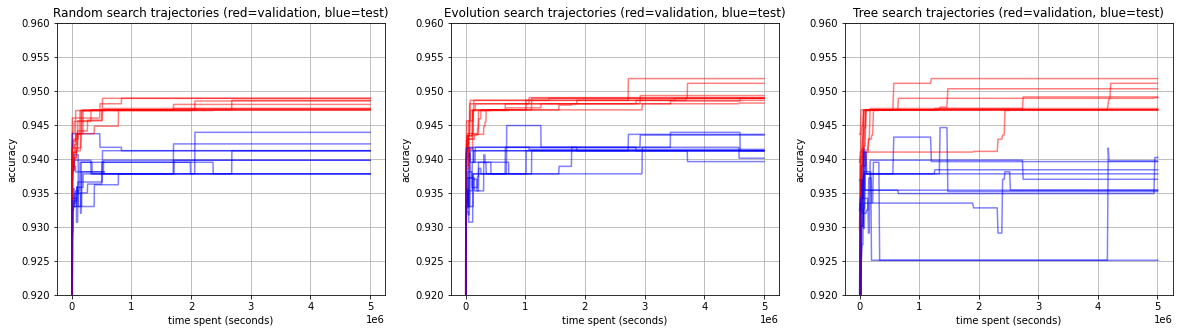

In [13]:
#Plot how the validation changes with time
plt.figure(figsize=(20, 5))
xlabel = 'time spent (seconds)' 
plt.subplot(1, 3, 1)
for times, best_valid, best_test in random_data:
  plt.plot(times, best_valid, label='valid', color='red', alpha=0.5) #range(1, len(times)+1)
  plt.plot(times, best_test, label='test', color='blue', alpha=0.5)

plt.ylabel('accuracy')
plt.xlabel(xlabel)
plt.ylim(0.92, 0.96)
plt.grid()
plt.title('Random search trajectories (red=validation, blue=test)')


plt.subplot(1, 3, 2)
for times, best_valid, best_test in evolution_data:
  plt.plot(times, best_valid, label='valid', color='red', alpha=0.5)
  plt.plot(times, best_test, label='test', color='blue', alpha=0.5)

plt.ylabel('accuracy')
plt.xlabel(xlabel)
plt.ylim(0.92, 0.96)
plt.grid()
plt.title('Evolution search trajectories (red=validation, blue=test)')

plt.subplot(1,3,3)
for times, best_valid, best_test in tree_search_data:
  plt.plot(times, best_valid, label='valid', color='red', alpha=0.5)
  plt.plot(times, best_test, label='test', color='blue', alpha=0.5)
plt.ylabel('accuracy')
plt.xlabel(xlabel)
plt.ylim(0.92, 0.96)
plt.grid()
plt.title('Tree search trajectories (red=validation, blue=test)')

Text(0.5, 1.0, 'Tree search trajectories (red=validation, blue=test)')

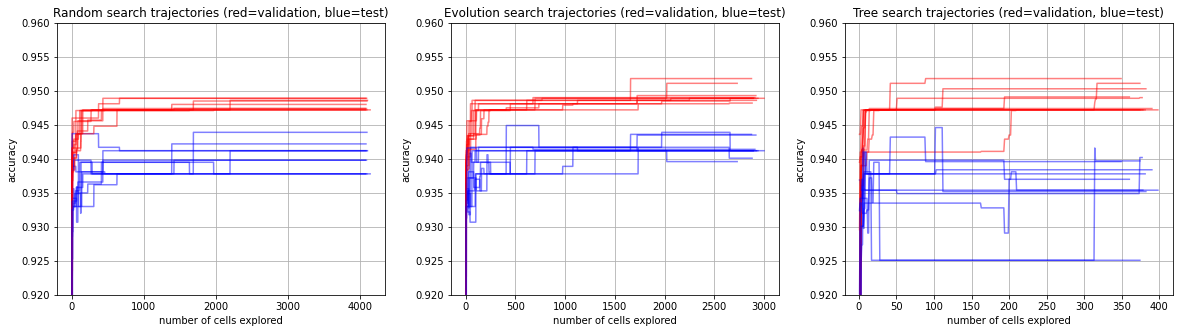

In [14]:
#Plot how the validation changes with number of cells visited
plt.figure(figsize=(20, 5))
xlabel = 'number of cells explored'
plt.subplot(1, 3, 1)
for times, best_valid, best_test in random_data:
  plt.plot(range(1, len(times)+1), best_valid, label='valid', color='red', alpha=0.5) #range(1, len(times)+1)
  plt.plot(range(1, len(times)+1), best_test, label='test', color='blue', alpha=0.5)

plt.ylabel('accuracy')
plt.xlabel(xlabel)
plt.ylim(0.92, 0.96)
plt.grid()
plt.title('Random search trajectories (red=validation, blue=test)')


plt.subplot(1, 3, 2)
for times, best_valid, best_test in evolution_data:
  plt.plot(range(1, len(times)+1), best_valid, label='valid', color='red', alpha=0.5)
  plt.plot(range(1, len(times)+1), best_test, label='test', color='blue', alpha=0.5)

plt.ylabel('accuracy')
plt.xlabel(xlabel)
plt.ylim(0.92, 0.96)
plt.grid()
plt.title('Evolution search trajectories (red=validation, blue=test)')

plt.subplot(1,3,3)
for times, best_valid, best_test in tree_search_data:
  plt.plot(range(1, len(times)+1), best_valid, label='valid', color='red', alpha=0.5)
  plt.plot(range(1, len(times)+1), best_test, label='test', color='blue', alpha=0.5)
plt.ylabel('accuracy')
plt.xlabel(xlabel)
plt.ylim(0.92, 0.96)
plt.grid()
plt.title('Tree search trajectories (red=validation, blue=test)')

10
10
10


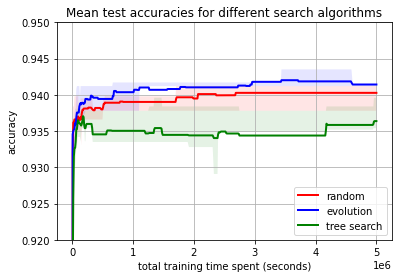

In [15]:
# Compare the mean test accuracy along with error bars.
def plot_data(data, color, label, gran=10000, max_budget=5e6):
  """Computes the mean and IQR fixed time steps."""
  print(len(data))
  xs = range(0, int(max_budget+1), gran) #500 
  mean = [0.0]
  per25 = [0.0]
  per75 = [0.0]
  
  repeats = len(data)
  pointers = [1 for _ in range(repeats)]
  
  cur = gran
  while cur < max_budget+1:
    all_vals = []
    for repeat in range(repeats):
      while (pointers[repeat] < len(data[repeat][0]) and 
             data[repeat][0][pointers[repeat]] < cur):
        pointers[repeat] += 1
      prev_time = data[repeat][0][pointers[repeat]-1]
      prev_test = data[repeat][2][pointers[repeat]-1]
      #print(data[repeat][0][:10])
      next_time = data[repeat][0][pointers[repeat]]
      next_test = data[repeat][2][pointers[repeat]]
      assert prev_time < cur and next_time >= cur

      # Linearly interpolate the test between the two surrounding points
      cur_val = ((cur - prev_time) / (next_time - prev_time)) * (next_test - prev_test) + prev_test
      
      all_vals.append(cur_val)
      
    all_vals = sorted(all_vals)
    mean.append(sum(all_vals) / float(len(all_vals)))
    per25.append(all_vals[int(0.25 * repeats)])
    per75.append(all_vals[int(0.75 * repeats)])
      
    cur += gran
    
  plt.plot(xs, mean, color=color, label=label, linewidth=2)
  plt.fill_between(xs, per25, per75, alpha=0.1, linewidth=0, facecolor=color)

plot_data(random_data, 'red', 'random')
plot_data(evolution_data, 'blue', 'evolution')
plot_data(tree_search_data, 'green', 'tree search')
plt.legend(loc='lower right')
plt.ylim(0.92, 0.95)
plt.xlabel('total training time spent (seconds)') #total number of cells explored = 1000')
plt.ylabel('accuracy')
plt.title("Mean test accuracies for different search algorithms")
plt.grid()

We see that the performance of the tree search is not very satisfactory. One of the reasons is that it is not exploring as many number of cells as random search or evolution search. But even when number of nodes is same, for high enough number of, the performance is not better. 

Tree Search performs well when we assume that the neighbouring points have similar rewards. So we test this assumption in the following code. 

Distance between two cells is measured as follows:
 1. We generate edge triplets (Node1, edge, Node2)  for each cell, as cell is a DAG. 
 2. Distance is how many tuples are in cell1 that are not in cell2, plus the size difference between cell1 and cell2. 

The distance is commutative. 

In [16]:
#find difference b/w two cells
def find_dist(cell1, cell2):
  """returns the distance between cell1 and cell2"""
  
  def gen_graph_tuple(cell):
    """generate tuples of connected nodes"""
    graph = []
    for i in range(cell.matrix.shape[0]):
      for j in range(i, cell.matrix.shape[1]):
        if cell.matrix[i][j] == 1:
          graph.append((cell.ops[i], cell.ops[j]))
    return graph

  cell1_graph = gen_graph_tuple(cell1)
  cell2_graph = gen_graph_tuple(cell2)

  # print(cell1_graph)
  # print(cell2_graph)

  #find distance between cell1 and cell2
  distance = 0
  num_edges_cell1 = len(cell1_graph)
  num_edges_cell2 = len(cell2_graph)
  for edge in cell1_graph:
    # print(edge)
    if edge not in cell2_graph:
      distance += 1
    else:
      cell2_graph.remove(edge)

  if num_edges_cell1 < num_edges_cell2:
    distance += (num_edges_cell2 - num_edges_cell1)

  return distance

As seen in the figure below, there is not a high correlation between distance and performance of CNN of composed of cells. That means, similar cells, don't necessarily yield similar accuracies. (So, tree search is not a good search algorithm for this dataset). 

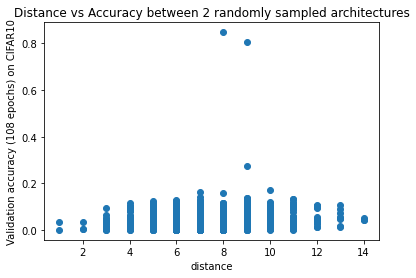

pearson correlation is  0.14690334473174121
p value  3.08598626305885e-06


In [17]:
#radomly sample the cells and compare their accuracies
from tqdm import tqdm
distances, diff_accuracies = [], []
for runs in range(1000):
  cell1 = Cell()
  cell2 = Cell()
  distances.append(find_dist(cell1, cell2))
  diff_accuracies.append(abs(cell1.get_val_accuracy(108, quick=True) - cell2.get_val_accuracy(108, quick=True)))

plt.scatter(distances, diff_accuracies)
plt.title("Distance vs Accuracy between 2 randomly sampled architectures")
plt.xlabel("distance")
plt.ylabel("Validation accuracy (108 epochs) on CIFAR10")
plt.show()
from scipy.stats import pearsonr
print("pearson correlation is ", pearsonr(distances, diff_accuracies)[0])
print("p value ", pearsonr(distances, diff_accuracies)[1])

### Training the sampled architecture using FashionMNIST dataset. 
Following are the functions useful for training randomly sampled architecture on Fashion MNIST data. 
We want to compare the performance of same architecutres on CIFAR-10 and some other dataset. Basically, we are trying to find out if the work done by NASBench-101 of training ~0.5m architectures can be useful to us for our own datasets. 
We choose FashionMNIST because:
1. It is very different from CIFAR-10 on which NASBench dataset is trained. (grayscale, about clothes)
2. It is not as simple as overused MNIST data. But simple enough to achieve good accuracy in low number of epochs. (~6 epochs)
3. Images are not big in size so many neural networks can be trained with the limited resources we have. 

In [18]:
def Train(net, trainloader, num_trains, args):
    num_epochs = args.epochs
    batch_size = args.batch_size
    lr = args.learning_rate
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=args.learning_rate, momentum=args.momentum, weight_decay=args.weight_decay)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, args.epochs)

    for epoch in range(num_epochs):
        net.train()

        scheduler.step()

        train_loss = 0
        correct = 0
        total = 0
        for batch_idx, (inputs, targets) in enumerate(trainloader):
            inputs, targets = inputs.to(device), targets.to(device)

            # forward
            outputs = net(inputs)

            # back-propagation
            optimizer.zero_grad()
            loss = criterion(outputs, targets)
            loss.backward()
            nn.utils.clip_grad_norm_(net.parameters(), args.grad_clip)
            optimizer.step()

            train_loss += loss.item()
            _, predict = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += predict.eq(targets.data).cpu().sum().item()
            if batch_idx % 100 == 0:
              print('Epoch=%d Batch=%d | Loss=%.3f, Acc=%.3f(%d/%d)' %
                    (epoch, batch_idx+1, train_loss/(batch_idx+1), correct/total, correct, total))

def Test(net, testloader, num_tests, predict_net=None):
    net.eval()
    criterion = nn.CrossEntropyLoss()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = net(inputs)

            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predict = torch.max(outputs.data, 1)
            correct += predict.eq(targets.data).cpu().sum().item()

        test_loss = test_loss/len(testloader)
        accuracy = correct/num_tests
        print('Testing: Loss=%.3f, Acc=%.3f(%d/%d)' %
              (test_loss, accuracy, correct, num_tests))

        return accuracy


In [19]:
def PrepareFashionMNIST(batch_size):
    print('--- Preparing Fashion MNIST Data ---')

    train_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Pad(2), #convert to shape [32,32]
        # transforms.Normalize((0.2860), (0.3205)), #no need to normalize fashion mnist
    ])

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Pad(2),
    ])

    trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=train_transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

    testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=test_transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)

    print('--- Fashion MNIST Data Prepared ---')

    return trainloader, len(trainset), testloader, len(testset)


In [20]:
#arguments of nn architecture for FashionMNIST
args = nn_generation.CustomDict()
args['module_vertices'] = 7
args['max_edges'] = 9
args['available_ops'] = ['conv3x3-bn-relu', 'conv1x1-bn-relu', 'maxpool3x3']
args['stem_out_channels'] = 128
args['num_stacks'] = 3
args['num_modules_per_stack'] = 3
args['batch_size'] = 128
args['epochs'] = 6
args['learning_rate'] = 0.025
args['lr_decay_method'] = 'COSINE_BY_STEP'
args['momentum'] = 0.9
args['weight_decay'] = 1e-4
args['grad_clip'] = 5
args['num_labels'] = 10
args['in_channels'] = 1 #For FashionMNIST


In [23]:
#randomly sample the cells. Train neural network on mnist. Compare accuracies(cifer and mnist)
#of sampled neural network 
import os
device = 'cuda'
#Download Fashion MNIST Data
trainloader, num_train, testloader, num_test = PrepareFashionMNIST(batch_size = 128)

#Load previous made accuracies df
accuracies_df = pd.read_csv("NAS_Search_using_NASBench-101/accuracies.csv").drop('Unnamed: 0', axis=1)

#load previously sampled architectures
sampled_cells = list(accuracies_df['cell'].values)

#train ~100 architectures 
for _ in range(100):
  cell = Cell()
  while cell in sampled_cells:
    cell = Cell()
  

  spec = api.ModelSpec(cell.matrix, cell.ops) 
  net = nn_generation.generate_net(spec, args) 
  net = net.to(device)

  Train(net, trainloader, num_train, args)
  mnist_test_acc = Test(net, testloader, num_test)

  accuracies = {'cifar_acc_12': cell.get_test_accuracy(12), 
                'cifar_acc_36': cell.get_test_accuracy(36),
                'cifar_acc_108': cell.get_test_accuracy(108),
                'mnist_test_acc': mnist_test_acc, 
              'cell': cell.get_id(),
              'imagenette_test_acc_36': 0,
              'imagenette_test_acc_12': 0,
                }

  accuracies_df = accuracies_df.append(accuracies, ignore_index=True)
  print(accuracies)

  accuracies_df.to_csv("NAS_Search_using_NASBench-101/accuracies.csv")


--- Preparing Fashion MNIST Data ---
--- Fashion MNIST Data Prepared ---


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch=0 Batch=1 | Loss=2.321, Acc=0.102(13/128)


KeyboardInterrupt: ignored

## Training the sampled architecture using Imagenette dataset.

We repeat the same procedure as before on Imagenette. But this time, the image dimensions (150,150). So, we add few more layers in the beginning of CNN. 

In [22]:
def PrepareImagenette(batch_size):
    print('--- Preparing Imagenette Data ---')
    ### Download the dataset ###
    dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/imagenette-160.tgz"
    download_url(dataset_url, '.')
    ### Extract from archive ###
    with tarfile.open('./imagenette-160.tgz', 'r:gz') as tar:
        tar.extractall(path='./data')
    
    ### Data transforms (normalization & data augmentation) ###

    stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    train_transforms = transforms.Compose([transforms.RandomCrop(150, padding=4, padding_mode='reflect'), 
                            transforms.RandomHorizontalFlip(), 
                            transforms.ToTensor(), 
                            transforms.Normalize(*stats,inplace=True)])
    valid_transforms = transforms.Compose([transforms.Resize([150,150]), transforms.ToTensor(), transforms.Normalize(*stats)])

    ### Making datasets ###
    train_set = ImageFolder('./data/imagenette-160/train', train_transforms)
    valid_set = ImageFolder('./data/imagenette-160/val', valid_transforms)

    ### PyTorch data loaders ###
    train_loader = DataLoader(train_set, batch_size, shuffle=True, num_workers=0, pin_memory=True)
    valid_loader = DataLoader(valid_set, batch_size*2, num_workers=0, pin_memory=True)

    print('--- Imagenette Data Prepared ---')

    return train_loader, len(train_set), valid_loader, len(valid_set)


In [25]:
#arguments of nn architecture for Imagenette
device = 'cuda'
args = nn_generation.CustomDict()
args['module_vertices'] = 7
args['max_edges'] = 9
args['available_ops'] = ['conv3x3-bn-relu', 'conv1x1-bn-relu', 'maxpool3x3']
args['stem_out_channels'] = 32
args['num_stacks'] = 3
args['num_modules_per_stack'] = 3
args['batch_size'] = 128
args['epochs'] = 12
args['learning_rate'] = 0.025
args['lr_decay_method'] = 'COSINE_BY_STEP'
args['momentum'] = 0.9
args['weight_decay'] = 1e-4
args['grad_clip'] = 5
args['num_labels'] = 10
args['in_channels'] = 3 #For Imagenette

In [26]:
# Construct a CNN for imagenette 
class ImagenetteConvNet(nn.Module):
    def __init__(self, net):
        """net is a smaller network generated by NASBench"""
        super(ImagenetteConvNet, self).__init__()
        self.conv3x3_input = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.conv3x3_input_with_pad = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1) 
        self.maxpool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv3x3_mid = nn.Conv2d(64, 32, 3, 1, 0)
        self.conv3x3_mid_with_pad = nn.Conv2d(32, 32, 3, 1, 1)
        self.conv1x1 = nn.Conv2d(32, 3, 1, 1, 0)
        self.batch_norm64 = nn.BatchNorm2d(64) #with learnable parameters
        self.batch_norm3 = nn.BatchNorm2d(3)
        self.net = net


    def forward(self, x):

        #---1st cell
        x1 = self.conv3x3_input_with_pad(self.conv3x3_input(x))
        x2 = self.conv3x3_input(x)
        x = torch.cat((x1, x2), 1) #filter concatenation
        x = self.maxpool(x)
        x = F.relu(x)
        x = self.batch_norm64(x)
        #---2nd cell
        x1 = self.conv3x3_mid_with_pad(self.conv3x3_mid(x))
        x2 = self.conv3x3_mid(x)
        x = torch.cat((x1, x2), 1)
        x = self.maxpool(x)
        x = F.relu(x)
        x = self.batch_norm64(x)
        #---3rd cell
        x = self.conv3x3_mid_with_pad(self.conv3x3_mid(x))
        x = F.relu(x)
        x = self.conv1x1(x)
        x = F.relu(x)
        x = self.batch_norm3(x)
        #---To the network generated by NAS
        x = self.net(x)

        return x


In [48]:
#randomly sample the cells. Train neural network on mnist. Compare accuracies(cifar and imagenette)
#of sampled neural network 
#Download Imagenette Data
trainloader, num_train, testloader, num_test = PrepareImagenette(batch_size = 128)

#Read the file
accuracies_df = pd.read_csv("NAS_Search_using_NASBench-101/accuracies.csv").drop('Unnamed: 0', axis=1)

for i in range(len(accuracies_df)):
    row = accuracies_df.loc[i]
    acc = row['imagenette_test_acc_'+str(args['epochs'])]
    if acc != 0:
        print("cell already trained")
        pass
    else:

        cell = Cell().construct_from_id(row['cell'])
        
        spec = api.ModelSpec(cell.matrix, cell.ops) 
        net = nn_generation.generate_net(spec, args) 
        net = ImagenetteConvNet(net)
        net = net.to(device)

        Train(net, trainloader, num_train, args)
        test_acc = Test(net, testloader, num_test)

        accuracies_df.loc[i, 'imagenette_test_acc_'+str(args['epochs'])] = test_acc

        print(accuracies_df)
        accuracies_df.to_csv("NAS_Search_using_NASBench-101/accuracies.csv")

        



--- Preparing Imagenette Data ---
Using downloaded and verified file: ./imagenette-160.tgz
--- Imagenette Data Prepared ---
cell already trained
cell already trained
cell already trained
cell already trained
cell already trained
cell already trained
cell already trained
cell already trained
cell already trained
cell already trained
cell already trained
cell already trained
cell already trained
cell already trained
cell already trained
cell already trained
cell already trained
cell already trained
cell already trained
cell already trained
cell already trained
cell already trained
cell already trained
cell already trained
cell already trained
cell already trained
cell already trained
cell already trained
cell already trained
cell already trained
cell already trained
cell already trained
cell already trained
cell already trained
cell already trained
cell already trained
cell already trained
cell already trained
cell already trained
cell already trained
cell already trained
cell already tr

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch=0 Batch=1 | Loss=2.312, Acc=0.125(16/128)


KeyboardInterrupt: ignored

## Visualization of results

In [ ]:
#Compute pearson correlation between accuracies of mnist and cifar
from scipy.stats import pearsonr, wilcoxon
import matplotlib.pyplot as plt
import pandas as pd
#load the dataframe
accuracies_df = pd.read_csv("NAS_Search_using_NASBench-101/accuracies.csv").drop('Unnamed: 0', axis=1)

mnist_acc = accuracies_df['mnist_test_acc']
EPOCHS = [12, 36, 108]
for epoch in EPOCHS:
  cifar_acc = accuracies_df['cifar_acc_'+str(epoch)]
  plt.scatter(cifar_acc, mnist_acc)
  plt.title("Randomly sampled model architecture accuracies (143 samples)")
  plt.xlabel("Cifar10 test accuracy (" + str(epoch) +" epochs)")  
  plt.ylabel("Fashion MNIST test accuracy")
  plt.show()
  r, p = pearsonr(mnist_acc, cifar_acc)
  print("pearson correlation: ", r)
  print("p value: ", p)
  w, p = wilcoxon(mnist_acc, cifar_acc)
  print("The p value that differences b/w two accuracies is symmetric about 0: ", p)


# plot cifar_acc vs imagenette_test_acc
cifar_acc_108 = accuracies_df['cifar_acc_108'].values[:21]
imagenette_test_acc_36 = accuracies_df['imagenette_test_acc_36'].values[:21]
plt.scatter(cifar_acc_108, imagenette_test_acc_36)
plt.title("Randomly sampled model architecture accuracies (21 samples)")
plt.xlabel("Cifar10 test accuracy (" + str(108) +" epochs)")  
plt.ylabel("Imagenette test accuracy (" + str(36) +" epochs)")
plt.show()
r, p = pearsonr(imagenette_test_acc_36, cifar_acc_108)
print("pearson correlation: ", r)
print("p value: ", p)




We notice that the performance of sampled architectures are highly correlated. The correlation is higher with large number of epochs, as network reaches more stability. 

This is a good news! If good architectures perform well on multiple datasets, it could give us a good starting point when we are selecting architecture for our own CNN project. 

We need to test the correlation between other datasets though before we can make any generalizations. 